## Plotting different viz

NOTE: These are done with the help of GPT-3.

### Data Skew LFW-10

/tmp/ipykernel_2182777/2574281616.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis', edgecolor='k')


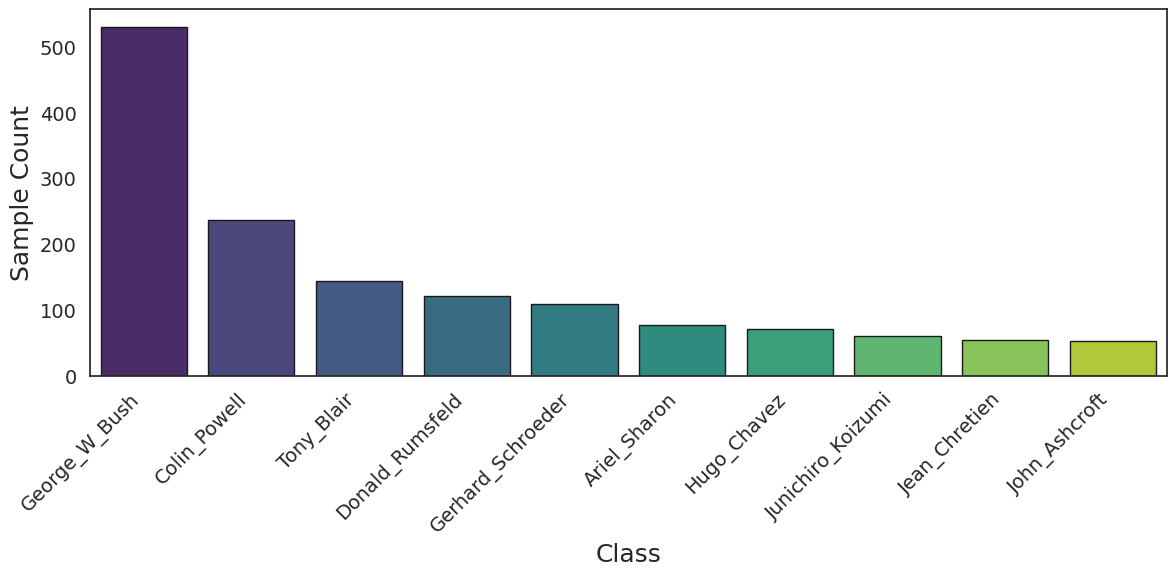

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms

# Load the dataset
def load_dataset(dataset_folder):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.436, 0.385, 0.344], std=[0.296, 0.269, 0.261])
    ])
    
    dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)
    return dataset

# Load your dataset
dataset_folder = '../data/lfw/'  # Update this path
dataset = load_dataset(dataset_folder)

# Prepare the data
class_names = dataset.classes
class_counts = [0] * len(class_names)

for _, label in dataset:
    class_counts[label] += 1

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Class': class_names,
    'Count': class_counts
})

# Sort the DataFrame by Count in descending order
df = df.sort_values(by='Count', ascending=False)

# Plot the number of samples per class using Seaborn
plt.figure(figsize=(12, 6))
# Set the plot style to remove the background grid
sns.set_style('white')
sns.barplot(x='Class', y='Count', data=df, palette='viridis', edgecolor='k')
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14)
plt.xlabel('Class', fontsize=18)
plt.ylabel('Sample Count', fontsize=18)
# plt.title('Number of Samples per Class', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping

# Save the plot as a high-resolution image for publication
plt.savefig('samples_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

## Training Graph

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import random

def set_seed(seed):
    """
    Set the seed for reproducibility.

    Args:
        seed (int): Seed value to set for random number generation.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set seed to be 42
set_seed(42)
device='cuda'

# Define hyperparameters for each model
best_hyperparams_resnet = {'lr': 0.01, 'batch_size': 16}
best_hyperparams_efficientnet = {'lr': 0.01, 'batch_size': 4}
best_hyperparams_inception = {'lr': 0.01, 'batch_size': 16}

# Define model creation functions
def create_resnet_model(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def create_efficientnet_model(num_classes):
    model = models.efficientnet_b2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def create_inception_v1_model(num_classes):
    model = models.googlenet(pretrained=False, aux_logits=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Initialize models
num_classes = 10
resnet_model = create_resnet_model(num_classes)
efficientnet_model = create_efficientnet_model(num_classes)
inception_model = create_inception_v1_model(num_classes)

def compute_class_weights(dataset):
    """
    Compute class weights for imbalanced classes.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset from which to compute class weights.
    
    Returns:
        torch.Tensor: A tensor of class weights.
    """
    class_indices = dataset.targets if hasattr(dataset, 'targets') else np.array([y for _, y in dataset])
    class_counts = torch.bincount(torch.tensor(class_indices))
    total_count = len(class_indices)
    class_weights = total_count / (len(np.unique(class_indices)) * class_counts.float())
    return class_weights

def create_criterion(class_weights):
    """Returns a criterion with class weights."""
    class_weights = class_weights.to(device)
    return nn.CrossEntropyLoss(weight=class_weights)

criterion = create_criterion(compute_class_weights(dataset).to(device))

# Initialize optimizers
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=best_hyperparams_resnet['lr'])
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=best_hyperparams_efficientnet['lr'])
optimizer_inception = optim.Adam(inception_model.parameters(), lr=best_hyperparams_inception['lr'])

/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torchvision/models/googlenet.py:46: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43636918, 0.38563913, 0.34477144],
                         std=[0.29639485, 0.2698132, 0.26158142])
])

# Set the dataset folder
dataset_folder = '../data/lfw/'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)
targets = np.array(dataset.targets)
num_classes = len(torch.unique(torch.tensor(targets)))

# Train-test split
train_indices, val_indices = train_test_split(np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42)
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)


# Create data loaders for ResNet18
train_loader_resnet = DataLoader(train_subset, batch_size=best_hyperparams_resnet['batch_size'], shuffle=True)
val_loader_resnet = DataLoader(val_subset, batch_size=best_hyperparams_resnet['batch_size'], shuffle=False)

# Create data loaders for EfficientNetB2
train_loader_efficientnet = DataLoader(train_subset, batch_size=best_hyperparams_efficientnet['batch_size'], shuffle=True)
val_loader_efficientnet = DataLoader(val_subset, batch_size=best_hyperparams_efficientnet['batch_size'], shuffle=False)

# Create data loaders for InceptionV1
train_loader_inception = DataLoader(train_subset, batch_size=best_hyperparams_inception['batch_size'], shuffle=True)
val_loader_inception = DataLoader(val_subset, batch_size=best_hyperparams_inception['batch_size'], shuffle=False)

In [4]:
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, early_stopping_patience=5):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct_preds += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs.argmax(1).cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        f1 = f1_score(all_labels, all_preds, average='macro')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, F1 Score: {f1:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), f'best_model.pth')
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {early_stopping_counter} epochs without improvement.')
            break

    return val_losses, val_accuracies

# Train and validate models with the corresponding loaders
val_losses_resnet, val_accs_resnet = train_and_validate_model(resnet_model, train_loader_resnet, val_loader_resnet, criterion, optimizer_resnet)
val_losses_efficientnet, val_accs_efficientnet = train_and_validate_model(efficientnet_model, train_loader_efficientnet, val_loader_efficientnet, criterion, optimizer_efficientnet)
val_losses_inception, val_accs_inception = train_and_validate_model(inception_model, train_loader_inception, val_loader_inception, criterion, optimizer_inception)

Epoch 1 - Loss: 3.1085, Accuracy: 0.0790
Validation Loss: 4.3789, Validation Accuracy: 0.1164, F1 Score: 0.0606
Epoch 2 - Loss: 2.3525, Accuracy: 0.0919
Validation Loss: 2.4845, Validation Accuracy: 0.0822, F1 Score: 0.0431
Epoch 3 - Loss: 2.3126, Accuracy: 0.1125
Validation Loss: 2.3646, Validation Accuracy: 0.1336, F1 Score: 0.0614
Epoch 4 - Loss: 2.3032, Accuracy: 0.1443
Validation Loss: 2.3335, Validation Accuracy: 0.1164, F1 Score: 0.0720
Epoch 5 - Loss: 2.2909, Accuracy: 0.1366
Validation Loss: 2.3053, Validation Accuracy: 0.1507, F1 Score: 0.0901
Epoch 6 - Loss: 2.2773, Accuracy: 0.1555
Validation Loss: 2.2687, Validation Accuracy: 0.2192, F1 Score: 0.1520
Epoch 7 - Loss: 2.2617, Accuracy: 0.1392
Validation Loss: 2.3017, Validation Accuracy: 0.1678, F1 Score: 0.1062
Epoch 8 - Loss: 2.2273, Accuracy: 0.1486
Validation Loss: 2.3440, Validation Accuracy: 0.1301, F1 Score: 0.1045
Epoch 9 - Loss: 2.2404, Accuracy: 0.1452
Validation Loss: 2.2549, Validation Accuracy: 0.1267, F1 Score:

/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1 - Loss: 2.8485, Accuracy: 0.0954
Validation Loss: 3.5010, Validation Accuracy: 0.1884, F1 Score: 0.0881


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 2 - Loss: 2.3612, Accuracy: 0.0936
Validation Loss: 2.3385, Validation Accuracy: 0.1404, F1 Score: 0.0957


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 3 - Loss: 2.3252, Accuracy: 0.1108
Validation Loss: 2.3076, Validation Accuracy: 0.0342, F1 Score: 0.0068


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 4 - Loss: 2.3274, Accuracy: 0.1091
Validation Loss: 2.3192, Validation Accuracy: 0.1027, F1 Score: 0.0480


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 5 - Loss: 2.3339, Accuracy: 0.1538
Validation Loss: 2.2747, Validation Accuracy: 0.1918, F1 Score: 0.1176


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 6 - Loss: 2.3040, Accuracy: 0.1400
Validation Loss: 2.2459, Validation Accuracy: 0.1199, F1 Score: 0.0643


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 7 - Loss: 2.3109, Accuracy: 0.1349
Validation Loss: 2.2395, Validation Accuracy: 0.2021, F1 Score: 0.1075


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 8 - Loss: 2.2724, Accuracy: 0.1280
Validation Loss: 2.4020, Validation Accuracy: 0.0788, F1 Score: 0.0564


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 9 - Loss: 2.3034, Accuracy: 0.1400
Validation Loss: 2.2872, Validation Accuracy: 0.0822, F1 Score: 0.0404


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 10 - Loss: 2.2516, Accuracy: 0.1675
Validation Loss: 2.2884, Validation Accuracy: 0.1575, F1 Score: 0.0762


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 11 - Loss: 2.2484, Accuracy: 0.1151
Validation Loss: 2.2957, Validation Accuracy: 0.1575, F1 Score: 0.0989


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 12 - Loss: 2.2023, Accuracy: 0.1658
Validation Loss: 2.2090, Validation Accuracy: 0.1849, F1 Score: 0.0741


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 13 - Loss: 2.1652, Accuracy: 0.1753
Validation Loss: 2.1589, Validation Accuracy: 0.2500, F1 Score: 0.0996


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 14 - Loss: 2.1305, Accuracy: 0.1624
Validation Loss: 2.1377, Validation Accuracy: 0.1507, F1 Score: 0.1164


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 15 - Loss: 2.0557, Accuracy: 0.1667
Validation Loss: 2.2328, Validation Accuracy: 0.1575, F1 Score: 0.0991


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 16 - Loss: 2.1096, Accuracy: 0.2096
Validation Loss: 2.1527, Validation Accuracy: 0.3801, F1 Score: 0.1577


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 17 - Loss: 1.9863, Accuracy: 0.1847
Validation Loss: 1.9355, Validation Accuracy: 0.1678, F1 Score: 0.1521


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 18 - Loss: 1.9809, Accuracy: 0.1675
Validation Loss: 2.2030, Validation Accuracy: 0.2158, F1 Score: 0.1618


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 19 - Loss: 1.8892, Accuracy: 0.2113
Validation Loss: 1.9059, Validation Accuracy: 0.1781, F1 Score: 0.1890


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 20 - Loss: 1.8461, Accuracy: 0.2208
Validation Loss: 1.8839, Validation Accuracy: 0.2603, F1 Score: 0.2423


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 21 - Loss: 1.7916, Accuracy: 0.2405
Validation Loss: 2.3546, Validation Accuracy: 0.2534, F1 Score: 0.1988


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 22 - Loss: 1.7757, Accuracy: 0.2818
Validation Loss: 1.7509, Validation Accuracy: 0.3288, F1 Score: 0.3099


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 23 - Loss: 1.6912, Accuracy: 0.2852
Validation Loss: 1.7413, Validation Accuracy: 0.2432, F1 Score: 0.2347


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 24 - Loss: 1.6304, Accuracy: 0.3428
Validation Loss: 1.9502, Validation Accuracy: 0.2432, F1 Score: 0.2654


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 25 - Loss: 1.5316, Accuracy: 0.3857
Validation Loss: 1.6272, Validation Accuracy: 0.3082, F1 Score: 0.3577


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 26 - Loss: 1.4495, Accuracy: 0.3668
Validation Loss: 1.7006, Validation Accuracy: 0.2808, F1 Score: 0.3009


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 27 - Loss: 1.3996, Accuracy: 0.4244
Validation Loss: 1.4715, Validation Accuracy: 0.3801, F1 Score: 0.4348


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 28 - Loss: 1.3450, Accuracy: 0.4579
Validation Loss: 1.4976, Validation Accuracy: 0.4486, F1 Score: 0.4290


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 29 - Loss: 1.2444, Accuracy: 0.4854
Validation Loss: 1.6396, Validation Accuracy: 0.5445, F1 Score: 0.4828


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 30 - Loss: 1.2082, Accuracy: 0.4983
Validation Loss: 1.4864, Validation Accuracy: 0.3151, F1 Score: 0.3704


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 31 - Loss: 1.0591, Accuracy: 0.5524
Validation Loss: 1.0542, Validation Accuracy: 0.5616, F1 Score: 0.5452


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 32 - Loss: 1.0478, Accuracy: 0.5936
Validation Loss: 1.6609, Validation Accuracy: 0.4623, F1 Score: 0.4482


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 33 - Loss: 0.9862, Accuracy: 0.6108
Validation Loss: 1.4112, Validation Accuracy: 0.6062, F1 Score: 0.5761


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 34 - Loss: 0.8625, Accuracy: 0.6684
Validation Loss: 1.3362, Validation Accuracy: 0.5411, F1 Score: 0.5263


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 35 - Loss: 0.7776, Accuracy: 0.7002
Validation Loss: 1.3498, Validation Accuracy: 0.4418, F1 Score: 0.4914


/home/sadat/miniconda3/envs/cs721/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 36 - Loss: 0.8535, Accuracy: 0.6701
Validation Loss: 1.5099, Validation Accuracy: 0.5308, F1 Score: 0.4902
Early stopping triggered after 5 epochs without improvement.


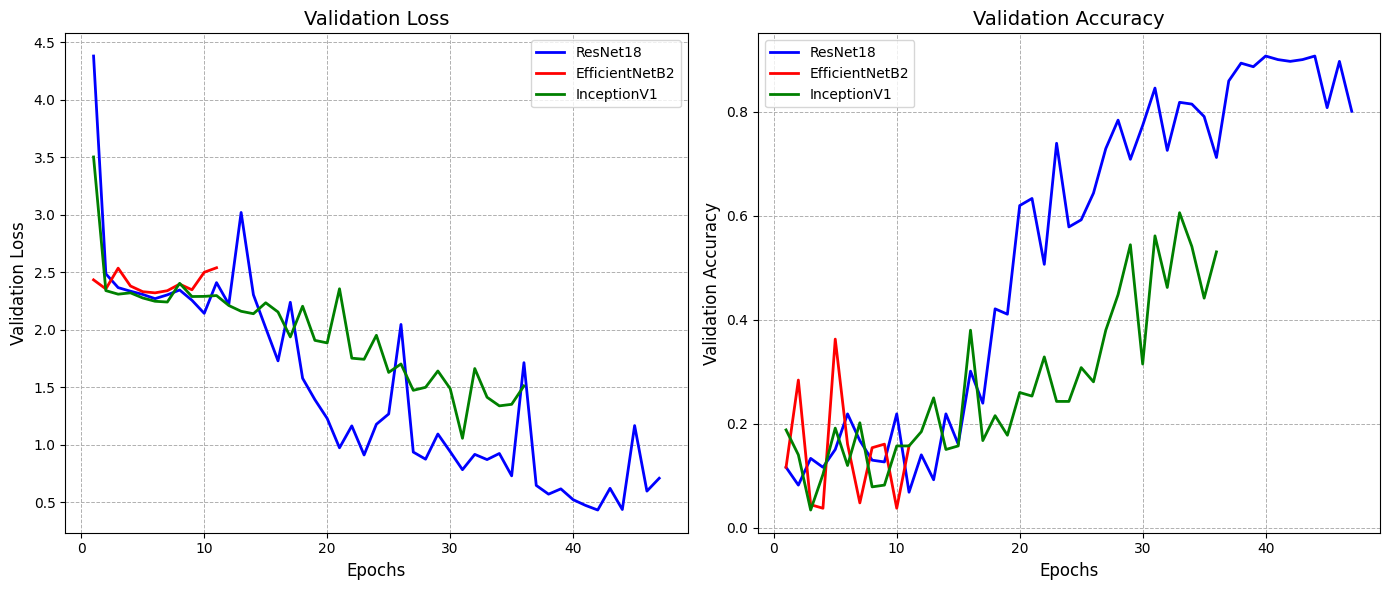

In [5]:
import matplotlib.pyplot as plt

# Define epoch ranges for each model
epochs_resnet = range(1, len(val_losses_resnet) + 1)
epochs_efficientnet = range(1, len(val_losses_efficientnet) + 1)
epochs_inception = range(1, len(val_losses_inception) + 1)

plt.figure(figsize=(14, 6))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_resnet, val_losses_resnet, 'b-', linewidth=2, label='ResNet18')
plt.plot(epochs_efficientnet, val_losses_efficientnet, 'r-', linewidth=2, label='EfficientNetB2')
plt.plot(epochs_inception, val_losses_inception, 'g-', linewidth=2, label='InceptionV1')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_resnet, val_accs_resnet, 'b-', linewidth=2, label='ResNet18')
plt.plot(epochs_efficientnet, val_accs_efficientnet, 'r-', linewidth=2, label='EfficientNetB2')
plt.plot(epochs_inception, val_accs_inception, 'g-', linewidth=2, label='InceptionV1')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Validation Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.savefig('validation_loss_accuracy.png')
plt.show()

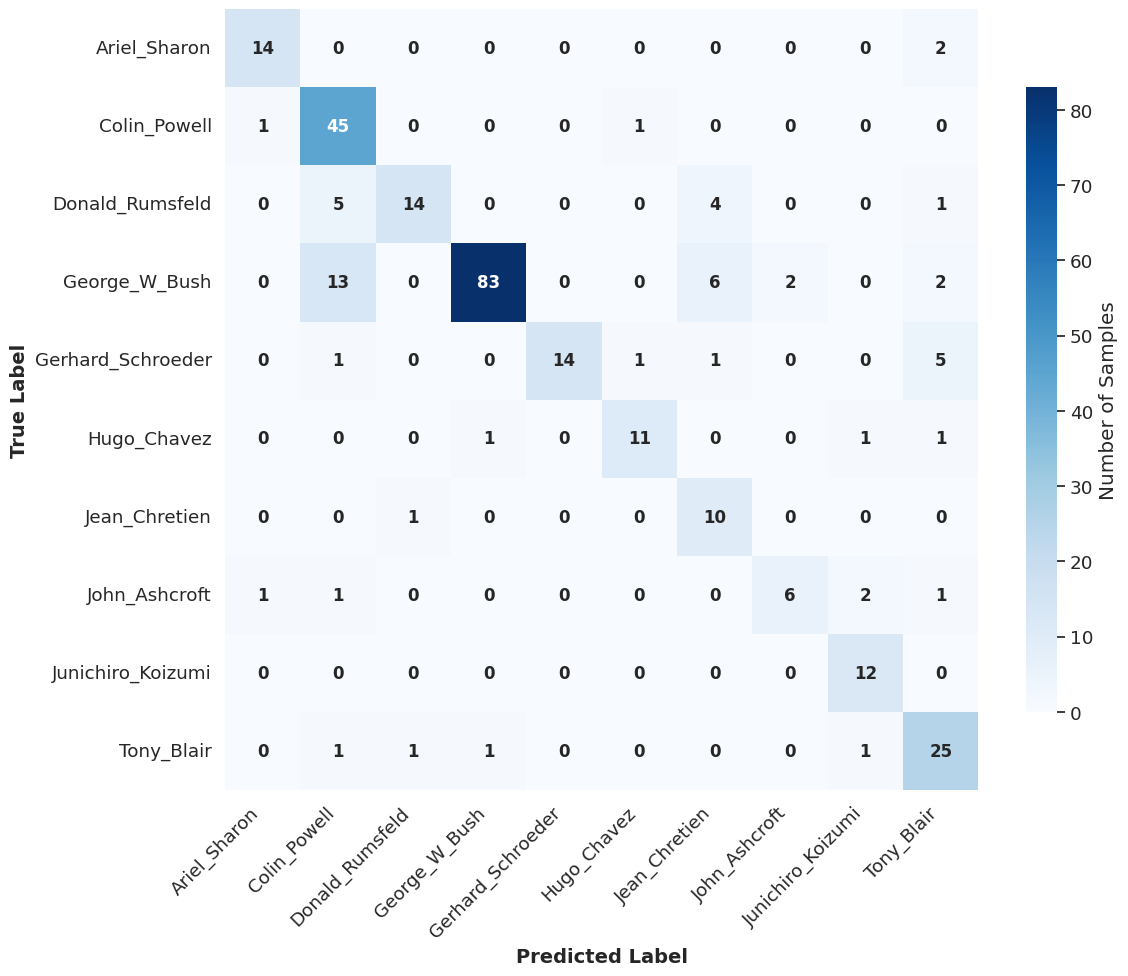

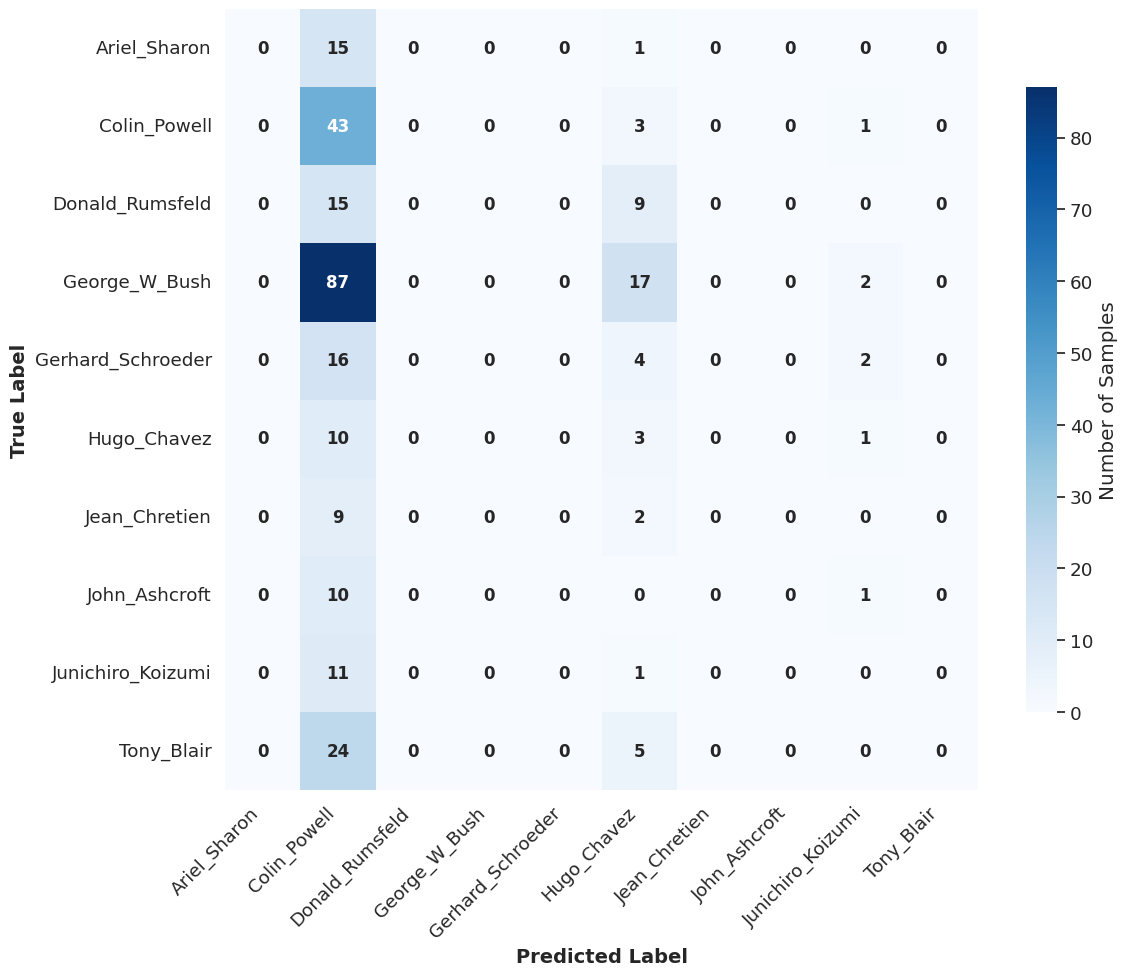

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

def validate_and_plot(model, val_loader, class_names, device, save_path):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(12, 10))
    sns.set(style='dark', font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                     cbar_kws={'shrink': .8, 'label': 'Number of Samples'},
                     annot_kws={"size": 12, "weight": 'bold'}, 
                     xticklabels=class_names, yticklabels=class_names)
    
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    # ax.set_title('Confusion Matrix Heatmap', fontsize=16, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

# Assuming you have the models and loaders ready and `class_names` defined
class_names = dataset.classes
validate_and_plot(resnet_model, val_loader_resnet, class_names, device, 'confusion_matrix_resnet.png')
validate_and_plot(efficientnet_model, val_loader_efficientnet, class_names, device, 'confusion_matrix_efficientnet.png')

# validate_and_plot(efficientnet_model, val_loader_efficientnet, class_names, device)
# validate_and_plot(inception_model, val_loader_inception, class_names, device)

In [8]:
import os

def save_incorrect_images(model, data_loader, save_dir):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in incorrect_indices:
                img = images[idx].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * np.array([0.29639485, 0.2698132, 0.26158142]) + np.array([0.43636918, 0.38563913, 0.34477144]), 0, 1)
                plt.imshow(img)
                plt.title(f'True: {labels[idx].item()}, Pred: {preds[idx].item()}')
                plt.axis('off')
                plt.savefig(os.path.join(save_dir, f'incorrect_{i}_{idx}.png'))
                plt.close()

# Save incorrectly predicted images
save_incorrect_images(resnet_model, val_loader_resnet, 'incorrect_images_resnet')
save_incorrect_images(efficientnet_model, val_loader_efficientnet, 'incorrect_images_efficientnet')
save_incorrect_images(inception_model, val_loader_inception, 'incorrect_images_inception')